In [1]:
# !pip install cmasher matplotlib-label-lines

In [2]:
import numpy as np
import cmasher as cmr
from scipy.special import comb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from labellines import labelLine, labelLines

## Parameters

In [3]:
linewidth = 3.0
fontsize = 20

indent_binet = 0.0
xvals_binet = (0.2, 0.5)

cell_size = 3500
gene_size = 3000

## Visualization of Single-Cell Count Matrix

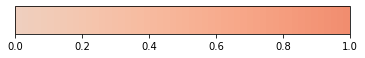

In [4]:
cmap = cmr.get_sub_cmap(plt.cm.coolwarm, 0.58, 0.78)

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
 
norm = mpl.colors.Normalize(vmin=0, vmax=1)
 
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
 
plt.show()

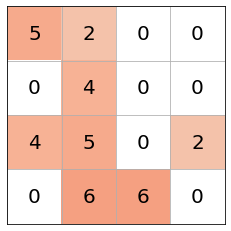

In [5]:
ncells = 4
ngenes = 4
ngrid = ncells * ngenes
nval = 8
maxval = 8

random_state = np.random.RandomState(seed=42)

gridid = random_state.choice(ngrid, nval, replace=False)
gridval = random_state.randint(1, maxval, size=nval)

data = np.zeros(ngrid)
data[gridid] = gridval
data = np.ma.array(data.reshape((ncells, ngenes)), mask=data==0)

norm = mpl.colors.Normalize(0, maxval)
colors = [cmap(norm(x)) for x in range(maxval)]
val_color = dict(zip(range(maxval), colors))


fig, ax = plt.subplots()
ax.matshow(data, vmin=0, vmax=maxval, cmap=cmap)

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=fontsize)

ax.set_xticks(np.arange(ncells+1)-0.5, minor=True)
ax.set_yticks(np.arange(ngenes+1)-0.5, minor=True)
ax.grid(which="minor")
ax.tick_params(which="minor", size=0)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Generating a Bipartite Graph Based on the Count Matrix

In [6]:
def genTriangle(pointPair):
    n = pointPair.shape[0]-1
    k = np.arange(0,n+1,1)
    b = comb(n,k)
    return b, k


def genWeight(pointPair,split=100):
    n = pointPair.shape[0]-1
    sep = 1/split
    t = np.arange(0,1+sep,sep)
    t = t.reshape(-1,1)
    oneMinusT = 1-t
    b, k = genTriangle(pointPair)
    weight = np.power(t,k)*np.power(oneMinusT,n-k)*b
    return weight


def getBesLine(pointPair,split=100):
    weight = genWeight(pointPair,split)
    x = np.sum(weight*pointPair[:,0],axis=1)
    y = np.sum(weight*pointPair[:,1],axis=1)
    line = np.concatenate([x.reshape(-1,1),y.reshape(-1,1)],axis=1)
    return line

In [7]:
cell_cmap = plt.cm.tab20([1, 3, 5, 7])
gene_cmap = plt.cm.tab20([9, 13, 17, 19])

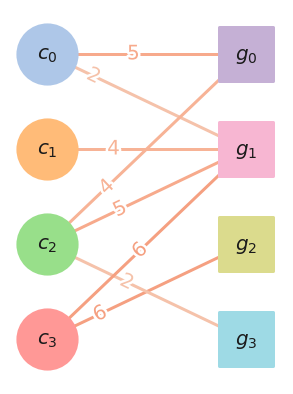

In [8]:
fig, ax = plt.subplots(figsize=(5, 7))

cell_coords = []
for i in range(ncells):
    cell_coords.append((0, ncells-i-1))
cell_coords = np.array(cell_coords)

gene_coords = []
for i in range(ngenes):
    gene_coords.append((1, ngenes-i-1))
gene_coords = np.array(gene_coords)

# Draw cells and genes
n = 0
for coord in cell_coords:
    ax.scatter(coord[0], coord[1], marker='o', lw=linewidth, color=cell_cmap[n], s=cell_size, zorder=3)
    ax.annotate('$c_{{{}}}$'.format(n), (coord[0], coord[1]-0.05), ha='center', fontsize=fontsize, color='#1b1b1b')
    n += 1

n = 0
for coord in gene_coords:
    ax.scatter(coord[0], coord[1], marker='s', lw=linewidth, color=gene_cmap[n], s=gene_size, zorder=3)
    ax.annotate('$g_{{{}}}$'.format(n), (coord[0], coord[1]-0.05), ha='center', fontsize=fontsize, color='#1b1b1b')
    n += 1
    
# Draw bipartite graph
indent = indent_binet
for i in range(ncells):
    for j in range(ngenes):
        i = ncells - i - 1
        val = data[i, j]
        if val > 0:           
            pointPair = np.array([cell_coords[i], gene_coords[j]])
            pointPairBes = [(x + d, y) for x, y in pointPair for d in (-indent, 0, indent)][1:-1]
            pointPairBes = np.array(pointPairBes)
            line = getBesLine(pointPairBes)
            ax.plot(line[:, 0], line[:, 1], color=val_color[val], lw=linewidth, label=str(int(val)))       

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.5, ncells-0.5)
ax.set_xlim(-0.2, 1.2)
ax.set_frame_on(False)
labelLines(plt.gca().get_lines(), xvals=xvals_binet, fontsize=fontsize)

plt.show()

## Calculating Complexities from Count Matrix

In [9]:
def cg_complexity(mcg, nmax=6):
    mcg = mcg.astype(np.float64)
    mgc = np.transpose(mcg)
    
    kc = []
    kg = []
    
    kc.append(np.sum(mcg, axis=1))
    kg.append(np.sum(mcg, axis=0))

    for n in range(1, nmax):
        kcn = np.dot(mcg, np.transpose([kg[n-1]])).flatten() / kc[0]
        kgn = np.dot(mgc, np.transpose([kc[n-1]])).flatten() / kg[0]
        kc.append(kcn)
        kg.append(kgn)

    kc = np.array(kc)
    kg = np.array(kg)
    
    return kc, kg

In [10]:
data = np.array(data)
kc, kg = cg_complexity(data, nmax=20)

## Visulization of $N$-order Complexity

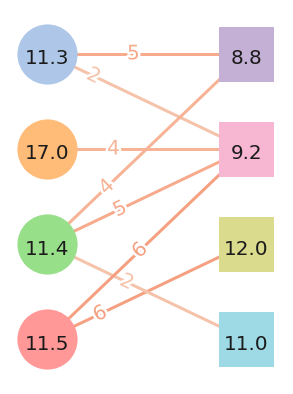

In [11]:
N = 1

fig, ax = plt.subplots(figsize=(5, 7))

cell_coords = []
for i in range(ncells):
    cell_coords.append((0, ncells-i-1))
cell_coords = np.array(cell_coords)

gene_coords = []
for i in range(ngenes):
    gene_coords.append((1, ngenes-i-1))
gene_coords = np.array(gene_coords)

# draw cells and genes
k = 0
for coord in cell_coords:
    ax.scatter(coord[0], coord[1], marker='o', color=cell_cmap[k], s=cell_size, zorder=3)
    ax.annotate('{:.1f}'.format(kc[N][k]), (coord[0], coord[1]-0.1), ha='center', fontsize=fontsize, color='#1b1b1b')
    k += 1

k = 0
for coord in gene_coords:
    ax.scatter(coord[0], coord[1], marker='s', color=gene_cmap[k], s=gene_size, zorder=3)
    ax.annotate('{:.1f}'.format(kg[N][k]), (coord[0], coord[1]-0.1), ha='center', fontsize=fontsize, color='#1b1b1b')
    k += 1

cell_cp0 = np.sum(data, axis=1)
gene_cp0 = np.sum(data, axis=0)
    
#  Draw bipartite graph
indent = indent_binet
for i in range(ncells):
    for j in range(ngenes):
        i = ncells - i - 1
        val = data[i, j]
        if val > 0:           
            pointPair = np.array([cell_coords[i], gene_coords[j]])
            pointPairBes = [(x + d, y) for x, y in pointPair for d in (-indent, 0, indent)][1:-1]
            pointPairBes = np.array(pointPairBes)
            line = getBesLine(pointPairBes)
            ax.plot(line[:, 0], line[:, 1], color=val_color[val], lw=linewidth, label=str(int(val)))       

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.5, ncells-0.5)
ax.set_xlim(-0.2, 1.2)
ax.set_frame_on(False)
labelLines(plt.gca().get_lines(), xvals=xvals_binet, fontsize=fontsize)

plt.show()

## Ranking Cells by Complexity

In [12]:
order_list = [0, 1, 2, 3, 4]
t = []
for order in order_list:
    argsort_cpl = np.argsort(kc[order])
    ls = []
    for i in range(ncells):
        ls.append(ncells - 1 - np.where(argsort_cpl==i)[0][0])
    t.append(ls)

t = np.array(t)
t = np.transpose(t)

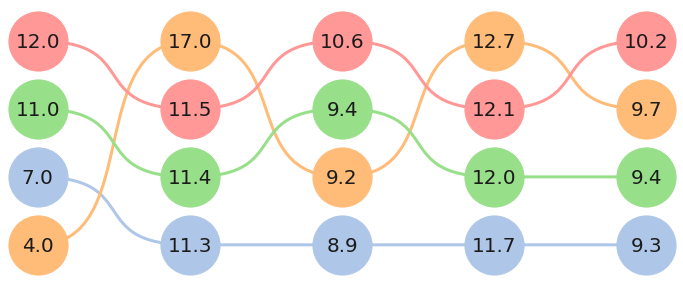

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

indent = 0.7

colors = cell_cmap
m = 0
for tj, color in zip(t, colors):
    ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=cell_size, zorder=3)
    n = 0
    for x, y in zip(np.arange(len(tj)), tj):
        ax.annotate('{:.1f}'.format(kc[n][m]), (x, y+0.1), ha='center', fontsize=fontsize, color='#1b1b1b')
        n += 1
    verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=linewidth, edgecolor=color)
    ax.add_patch(patch)
    m += 1

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.5, ncells-0.5)
ax.set_frame_on(False)
ax.invert_yaxis()

plt.show()

## Ranking Genes by Complexity

In [14]:
order_list = [0, 1, 2, 3, 4]
t = []

for order in order_list:
    argsort_cpl = np.argsort(kg[order])
    ls = []
    for i in range(ngenes):
        ls.append(ngenes - 1 - np.where(argsort_cpl==i)[0][0])
    t.append(ls)

t = np.array(t)
t = np.transpose(t)

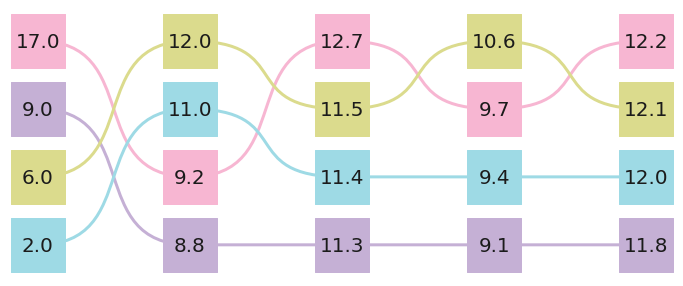

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

indent = 0.7

colors = gene_cmap
m = 0
for tj, color in zip(t, colors):
    ax.scatter(np.arange(len(tj)), tj, marker='s', color=color, s=gene_size, zorder=3)
    n = 0
    for x, y in zip(np.arange(len(tj)), tj):
        ax.annotate('{:.1f}'.format(kg[n][m]), (x, y+0.1), ha='center', fontsize=fontsize, color='#1b1b1b')
        n += 1
    verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=linewidth, edgecolor=color)
    ax.add_patch(patch)
    m += 1
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.5, ngenes-0.5)
ax.set_frame_on(False)
ax.invert_yaxis()

plt.show()